In [1]:
import triangle as tr

import numpy as np

import scienceplots
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.patches as patches
from cmap import Colormap

plt.style.use(["science"])

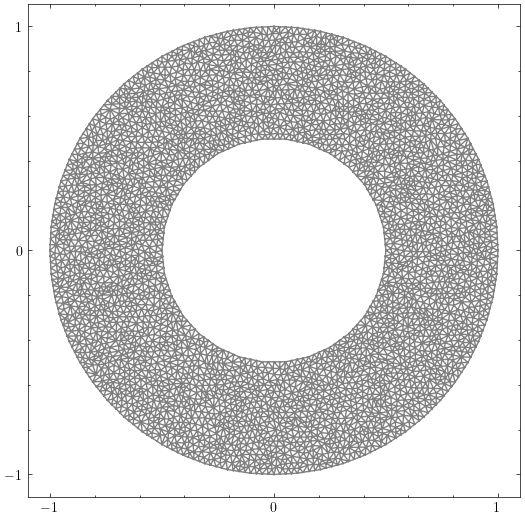

In [2]:
def circle(N, R):
    i = np.arange(N)
    theta = i * 2 * np.pi / N
    pts = np.stack([np.cos(theta), np.sin(theta)], axis=1) * R
    seg = np.stack([i, i + 1], axis=1) % N
    return pts, seg

pts0, seg0 = circle(60, 1.0)
pts1, seg1 = circle(30, 0.5)

pts = np.vstack([pts0, pts1])
seg = np.vstack([seg0, seg1 + seg0.shape[0]])
A = dict(vertices=pts, segments=seg, holes=[[0, 0]])
tri_data = tr.triangulate(A, f"DFpa{0.0005}")

Vs = tri_data['vertices']
Ts = tri_data['triangles']
Xs = Vs[:, 0]
Ys = Vs[:, 1]

datapoints = np.vstack([Xs, Ys]).T
triang = mtri.Triangulation(Xs, Ys, Ts)

np.save("donut_points", datapoints)
np.savez("donut_tri", tri_data)
np.savez("donut_mtri", triang)

fig, ax = plt.subplots(figsize=(0.8 * 8, 0.8 * 8))

plt.triplot(triang, lw=1, c="grey")
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_aspect('equal')
fig.savefig("donut_triangulation.pdf", format="pdf")

In [3]:
from itertools import combinations

data = {}
boundary_indices = [index for index in np.unique(tri_data["triangles"].ravel()) if (
    ((tri_data["vertices"][index] == [0., 1.]).sum() > 0) or
    ((tri_data["vertices"][index] == [1., 0.]).sum() > 0)
)]
edges = {}

# For K in T
size = len(tri_data["triangles"])

triangle_to_id = {}

for k_id, k in enumerate(tri_data["triangles"]):
    k_key = str(k)
    
    # Handle edges
    for edge in combinations(k, 2):
        edge = np.sort(edge, axis=0)
        edge_key = str(edge)
        
        if edge_key not in edges:
            edges[edge_key] = {"arr": edge, "vertices": np.array([tri_data["vertices"][index] for index in edge]), "connections": [k]}
        else:
            edges[edge_key]["connections"].append(k)
    
    # Set data dependent only on K
    triangle_to_id[k_key] = k_id
    data[k_id] = {}
    data[k_id]["triangle"] = k
    vertices = np.array([tri_data['vertices'][index] for index in k])
    area = np.abs(0.5 * np.cross(vertices[0] - vertices[1], vertices[0] - vertices[2]))
    data[k_id]["x_k"] = np.mean(vertices, axis=0)
    k_id += 1
    
datapoints = np.array([data[k_id]["x_k"] for k_id in range(len(Ts))])
np.save("donut_points", datapoints)

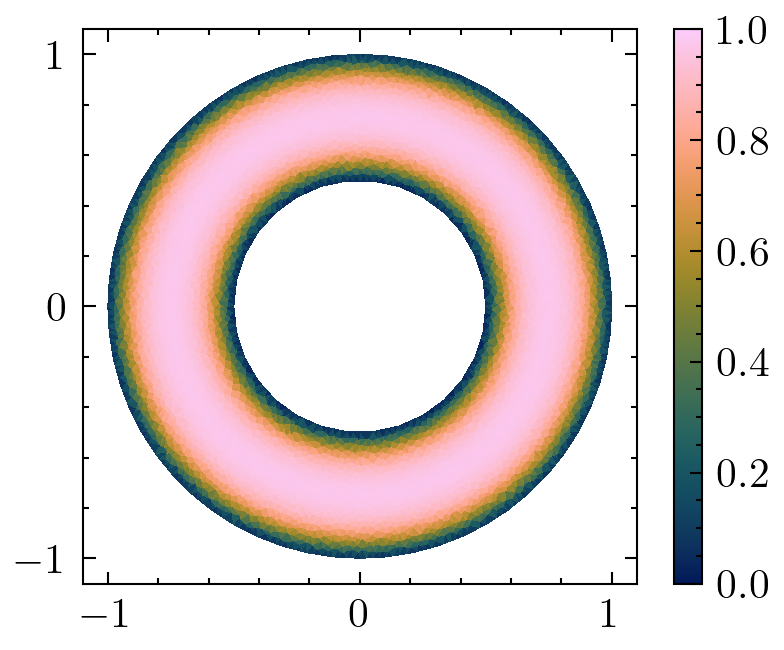

In [17]:
x, y = datapoints[:, 0], datapoints[:, 1]
sd = 0.1

tanh = np.tanh

r = np.sqrt(x**2 + y**2)

U_ansatz = tanh((r - 0.5)/sd)*tanh((1-r)/sd)

fig, ax = plt.subplots(figsize=(0.4 * 8, 0.3 * 8), dpi=300)
plt.tripcolor(triang, U_ansatz, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True, clim=(0, 1))
cbar = plt.colorbar()
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_aspect('equal')
fig.savefig("figs/donut_bc_smooth(sd=0.1).pdf", format="pdf")

# sd = 0.04

# U_ansatz = tanh((r - 0.5)/sd)*tanh((1-r)/sd)

# fig, ax = plt.subplots(figsize=(0.4 * 8, 0.3 * 8))
# plt.tripcolor(triang, U_ansatz, cmap=Colormap("crameri:batlow").to_mpl())
# ax.set_yticks([-1, 0, 1])
# ax.set_xticks([-1, 0, 1])
# ax.set_xlim([-1.1, 1.1])
# ax.set_ylim([-1.1, 1.1])
# ax.set_aspect('equal')
# fig.savefig("donut_bc_harsh(sd=0.04).pdf", format="pdf")